### Import libraries and read in file

In [39]:
# import libs
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor

plt.style.use('fivethirtyeight')

In [2]:
# read in file and define some useful column groupings
elec_w_weather_path = '/users/ianmyjer/desktop/disagg/electric_data_with_weather.csv'
df = pd.read_csv(elec_w_weather_path,delimiter=',',header=0,index_col=0,parse_dates=True)

In [3]:
# define useful column groupings
power_cols = ['north_br','south_br','basement','dryer','washer',
'dining_room','dishwasher','workbench','security_system',
'refrigerator','furnace_fan','garage','heat_pump',
'dhw_heater','main_house_total','office','outside_plug',
'rental_suite','entertainment','utility_room','unmetered',
'whole_house_total','oven']
weather_cols = ['Temp (C)', 'Dew Point Temp (C)', 'Rel Hum (%)', 
'Wind Spd (km/h)','Stn Press (kPa)']

In [105]:
df['main_house_total'].head(30);

### X Vars

In [5]:
def feature_creation(df):
    # starting features
    feature_cols = ['main_house_total','Temp (C)','Rel Hum (%)']
    
    # time-based features
    # only hour ever seemed to matter
    df['dow'] = df.index.weekday
    feature_cols.append('dow')
#     df['weekday'] = (df.index.weekday < 5)*1
#     df['business_hours'] = (df.index.weekday < 5)&(df.index.hour>=9)&(df.index.hour<=17)*1
    df['hour'] = df.index.hour
    feature_cols.append('hour')


    # season dummies
    # pretty much never important
#     df['winter'] = (df.index.month<=3)*1
#     df['spring'] = (df.index.month>3)&(df.index.month<=6)*1
#     df['summer'] = (df.index.month>6)&(df.index.month<=9)*1
#     df['fall'] = (df.index.month>9)*1

#     main house power percentage change and diff
#     pretty much never important
    for interval in [1,3,5,9,15]:
        df['mht_pct_'+str(interval)] = df['main_house_total'].pct_change(freq='1Min').fillna(0).replace(np.inf,1000)
        df['mht_diff_'+str(interval)] = df['main_house_total'].diff(periods=1).fillna(0)
        feature_cols.append('mht_pct_'+str(interval))
        feature_cols.append('mht_diff_'+str(interval))
    
    # rolling stats
    # smaller values seems to do better, which makes sense
    for time_val in [5,10,15,30,60]:
        df['rolling_sum_'+str(time_val)] = df['main_house_total'].rolling(time_val).sum().fillna(0)
        df['rolling_mean_'+str(time_val)] = df['main_house_total'].rolling(time_val).mean().fillna(0)
        df['rolling_max_'+str(time_val)]  = df['main_house_total'].rolling(time_val).max().fillna(0)
        df['rolling_min_'+str(time_val)]  = df['main_house_total'].rolling(time_val).min().fillna(0)
        df['rolling_median_'+str(time_val)]  = df['main_house_total'].rolling(time_val).median().fillna(0)
        feature_cols.append('rolling_sum_'+str(time_val))
        feature_cols.append('rolling_mean_'+str(time_val))
        feature_cols.append('rolling_max_'+str(time_val))
        feature_cols.append('rolling_min_'+str(time_val))
        feature_cols.append('rolling_median_'+str(time_val))

    return feature_cols

### ON/OFF Appliance Startups
Appliances that are either OFF and have 0 power draw or ON and have high power draw

In [10]:
of_apps = ['dishwasher', 'oven', 'dryer', 'washer']

In [11]:
# identify point when appliance starts up
# appliance must be using more than threshold power 
# and previous points must sum to a small number
for lbl in of_apps:
    # dishwashers seem to obey different rules than the other appliances
    if lbl == 'dishwasher':
        lower_thresh = df[lbl][df[lbl]>0].quantile(0.50)
    else:
        lower_thresh = df[lbl][df[lbl]>0].quantile(0.25)
    roll = df[lbl].rolling(20).sum().shift(1) # rolling sum shifted back 1 minute
    crit = (df[lbl] > lower_thresh)&(df[lbl] > roll) # criteria for appliance startup
    df[lbl+'_start'] = crit*1 # create binary column indicating appliance startup

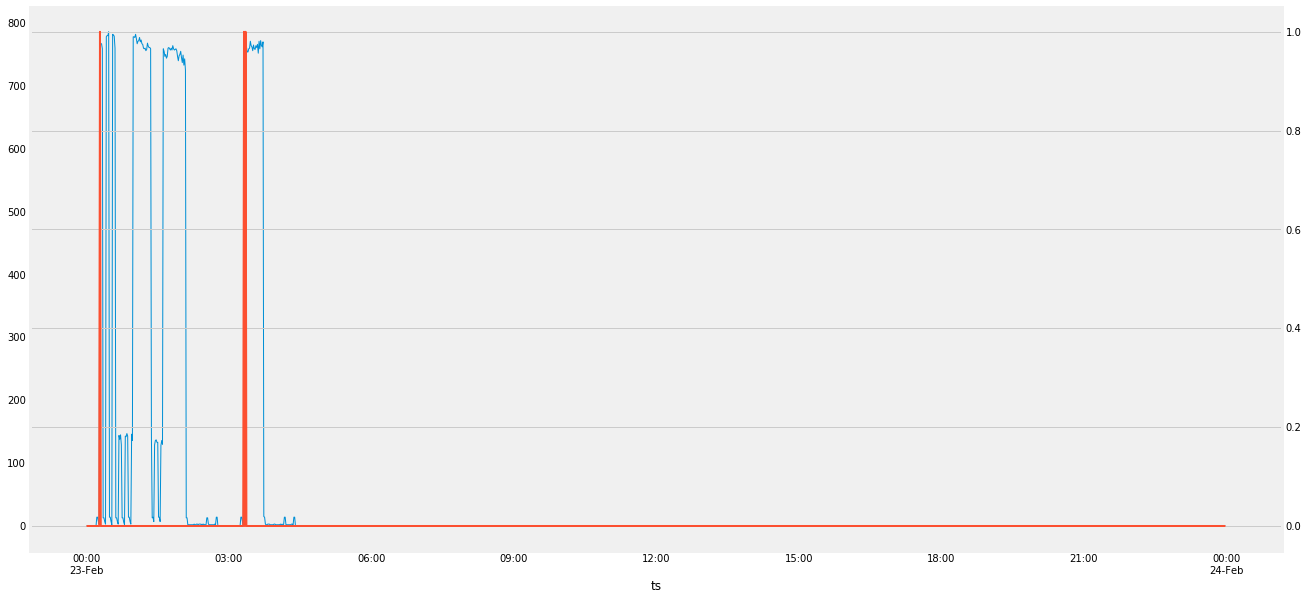

In [15]:
# plot spot checks to see if methodology works
lbl = 'dishwasher'
mask = (df.index.week==8)&(df.index.year==2013)&(df.index.day==23) #&(df.index.hour > 14)
df[lbl][mask].plot(linewidth=1,figsize=(20,10));
df[lbl+'_start'][mask].plot(secondary_y=True,linewidth=2,figsize=(20,10));

In [16]:
# loop through the calculted "start" columns
# find the "1s" and create a countdown starting at 60 mins from that point
# add column to dataframe
for lbl in of_apps:
    res = []
    for val in df[lbl+'_start']:
        if val == 1:
            res.append(60)
        elif not res:
            res.append(0)
        elif val == 0 and res[-1] != 0:
            res.append(res[-1]-1)
        else:
            res.append(0)

    res_shift = res[60:]
    res_shift.extend([0]*60)

    df[lbl+'_countdown'] = res_shift


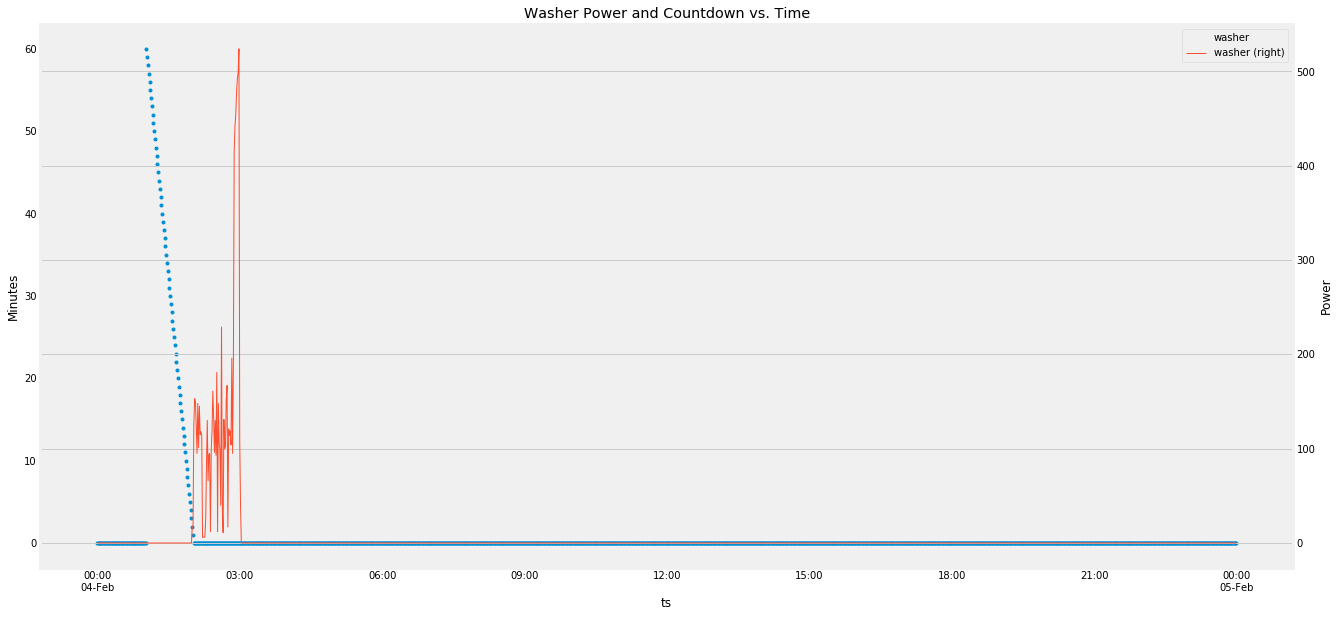

In [34]:
# plot spot checks to see if methodology works
lbl = 'washer'
mask = (df.index.week==6)&(df.index.year==2013)&(df.index.day==4) #&(df.index.hour > 14)
ax = df[lbl+'_countdown'][mask].plot(linewidth=1,figsize=(20,10),style='.',label=lbl,legend=True);
ax.set_ylabel('Minutes');
df[lbl][mask].plot(linewidth=1,ax=ax,secondary_y=True,legend=True);
plt.ylabel('Power');
plt.title('Washer Power and Countdown vs. Time')
plt.savefig('/users/ianmyjer/desktop/disagg/images/countdown.png')

### Attempt a basic model

In [36]:
# define X and y
feature_cols = feature_creation(df)
X = df[feature_cols]
y = df['washer_countdown']

In [92]:
# instead of just predicting a single appliance, is there a way to predict them as a group? 
# like "I want to predict any of the ON/OFF appliances will turn on in 60 mins"


In [37]:
# TRAIN TEST SPLIT 

# https://machinelearningmastery.com/backtest-machine-learning-models-time-series-forecasting/
# tscv = TimeSeriesSplit(n_splits=3)
# for train_index, test_index in tscv.split(X):
#     X_train, X_test = X.iloc[train_index], X.iloc[test_index]
#     y_train, y_test = y.iloc[train_index], y.iloc[test_index]

train_size = int(len(X) * 0.66)
X_train, X_test = X[0:train_size], X[train_size:len(X)]
y_train, y_test = y[0:train_size], y[train_size:len(X)]

In [38]:
linreg = LinearRegression()
linreg.fit(X_train, y_train)
y_pred = linreg.predict(X_test)
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test,y_pred)))
list(zip(feature_cols, linreg.coef_))

RMSE: 5.388571942380752


[('main_house_total', -5.37364436892733e-05),
 ('Temp (C)', 0.010699210871040213),
 ('Rel Hum (%)', -0.006664471570792628),
 ('dow', 0.06759746069198232),
 ('hour', 0.054177326295208085),
 ('mht_pct_1', 0.0023327297628650758),
 ('mht_diff_1', -3.0348639477621655e-06),
 ('mht_pct_3', 0.002332729762857605),
 ('mht_diff_3', -3.034863940316407e-06),
 ('mht_pct_5', 0.0023327297628561706),
 ('mht_diff_5', -3.0348639331696445e-06),
 ('mht_pct_9', 0.0023327297628586703),
 ('mht_diff_9', -3.034863942119083e-06),
 ('mht_pct_15', 0.0023327297628626736),
 ('mht_diff_15', -3.03486393222422e-06),
 ('rolling_sum_5', -4.333966447057566e-05),
 ('rolling_mean_5', -8.667932891786353e-06),
 ('rolling_max_5', 0.00013349553581202926),
 ('rolling_min_5', -7.3846730763152055e-06),
 ('rolling_median_5', 2.7291600426246516e-05),
 ('rolling_sum_10', -6.194228899990273e-06),
 ('rolling_mean_10', -6.194228903098897e-07),
 ('rolling_max_10', 8.620438075170999e-05),
 ('rolling_min_10', -1.553966369847136e-05),
 ('ro

In [41]:
ridgereg = Ridge(alpha=0.1, normalize=True)
ridgereg.fit(X_train, y_train)
y_pred = ridgereg.predict(X_test)
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
list(zip(feature_cols, ridgereg.coef_))

RMSE: 5.38827934531455


[('main_house_total', -5.820057528174867e-06),
 ('Temp (C)', 0.010624903745425289),
 ('Rel Hum (%)', -0.006615369730968369),
 ('dow', 0.06118005080390126),
 ('hour', 0.04933187300969528),
 ('mht_pct_1', 0.0023168347123997336),
 ('mht_diff_1', -2.0443768709732087e-06),
 ('mht_pct_3', 0.0023168347123997428),
 ('mht_diff_3', -2.044376870973282e-06),
 ('mht_pct_5', 0.002316834712399746),
 ('mht_diff_5', -2.044376870973278e-06),
 ('mht_pct_9', 0.002316834712399746),
 ('mht_diff_9', -2.044376870973282e-06),
 ('mht_pct_15', 0.0023168347123997454),
 ('mht_diff_15', -2.0443768709732815e-06),
 ('rolling_sum_5', -9.543953907872902e-07),
 ('rolling_mean_5', -4.771976953938426e-06),
 ('rolling_max_5', 5.789103267555132e-05),
 ('rolling_min_5', -3.2131083055572275e-05),
 ('rolling_median_5', -2.608954564162547e-05),
 ('rolling_sum_10', -1.931288914625991e-07),
 ('rolling_mean_10', -1.9312889146236304e-06),
 ('rolling_max_10', 6.904624727110853e-05),
 ('rolling_min_10', -1.1472374270012365e-05),
 ('r

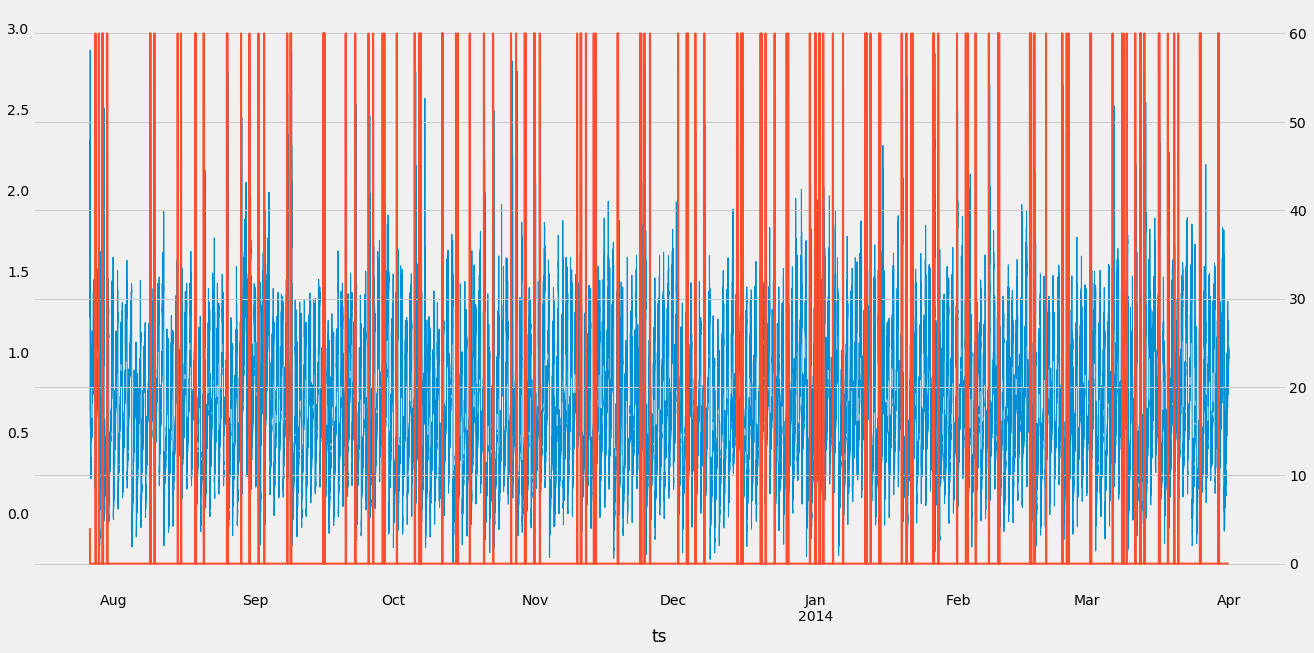

In [102]:
a = pd.DataFrame(data = {'yt':y_test, 'yp':y_pred}, columns=['yt','yp'])
# mask = 
a['yp'].plot(linewidth=1,figsize=(20,10));
a['yt'].plot(secondary_y=True,linewidth=2,figsize=(20,10));

In [46]:
lasso = Lasso(alpha=0.00005, normalize=True)
lasso.fit(X_train, y_train)
y_pred = lasso.predict(X_test)
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('R^2:', metrics.r2_score(y_test, y_pred))
list(zip(feature_cols, lasso.coef_))

RMSE: 5.389681099433449
R^2: 0.0077465818242890006


[('main_house_total', 0.0),
 ('Temp (C)', 0.005839641213879116),
 ('Rel Hum (%)', -0.0051037574647144045),
 ('dow', 0.04616899004878425),
 ('hour', 0.04963632475469772),
 ('mht_pct_1', 0.0),
 ('mht_diff_1', 0.0),
 ('mht_pct_3', 0.0),
 ('mht_diff_3', 0.0),
 ('mht_pct_5', 0.0),
 ('mht_diff_5', 0.0),
 ('mht_pct_9', 0.0),
 ('mht_diff_9', 0.0),
 ('mht_pct_15', 0.0),
 ('mht_diff_15', 0.0),
 ('rolling_sum_5', 0.0),
 ('rolling_mean_5', 0.0),
 ('rolling_max_5', 0.0),
 ('rolling_min_5', 0.0),
 ('rolling_median_5', 0.0),
 ('rolling_sum_10', 0.0),
 ('rolling_mean_10', 0.0),
 ('rolling_max_10', 1.8151763792525408e-05),
 ('rolling_min_10', -0.0),
 ('rolling_median_10', 0.0),
 ('rolling_sum_15', 0.0),
 ('rolling_mean_15', 0.0),
 ('rolling_max_15', 2.240560921538383e-05),
 ('rolling_min_15', -0.0),
 ('rolling_median_15', -0.0),
 ('rolling_sum_30', -0.0),
 ('rolling_mean_30', -0.0),
 ('rolling_max_30', 0.0),
 ('rolling_min_30', 0.0),
 ('rolling_median_30', -0.0),
 ('rolling_sum_60', -0.0),
 ('rolling_m

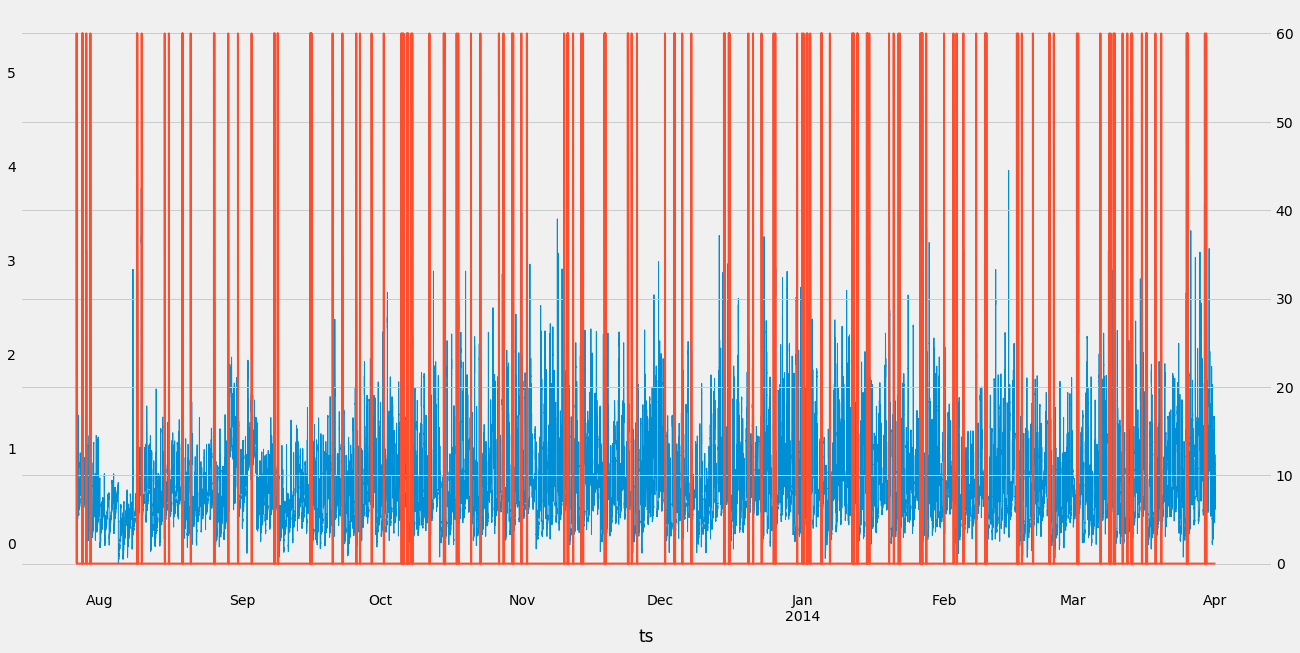

In [89]:
a = pd.DataFrame(data = {'yt':y_test, 'yp':y_pred}, columns=['yt','yp'])
a['yp'].plot(linewidth=1,figsize=(20,10));
a['yt'].plot(secondary_y=True,linewidth=2,figsize=(20,10));

In [40]:
treereg = RandomForestRegressor()
treereg.fit(X_train,y_train)
y_pred = treereg.predict(X_test)
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

RMSE: 6.296400754747292
